created using https://colab.research.google.com/drive/16NcbwnbRjDTwM_RweoKNbFMa3NMU4GYI?usp=sharing#scrollTo=YP9QDodGii1y

In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git



In [ ]:

%pip install omegaconf
%pip install pytorch_lightning
%pip install einops
%pip install gdown
%pip install matplotlib
#%pip install DALL-E

In [ ]:
%pip install ./taming-transformers/

#change find_packages() in setup.py to packages=['taming','taming.models','taming.models','taming.data'],

In [17]:
#@title 3. Lbraries importing
import io
import os
import sys
import yaml
import gdown
from math import sqrt
sys.path.append("./taming-transformers")

import requests
import numpy as np
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from einops import rearrange

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import torch
torch.set_grad_enabled(False);

from taming.models.vqgan import VQModel, GumbelVQ

In [2]:
#@title3DOWNLOADS SKIP
from pathlib import Path
url_template = 'https://drive.google.com/uc?id={}'
models_folder= Path('models')

os.makedirs(models_folder,exist_ok=True)

downloads=[
    {
    'id': '1M7RvSoiuKBwpF-98sScKng0lsZnwFebR',
    'name': 'vqgan.gumbelf8.config.yml',
    },
    {
    'id': '1WP6Li2Po8xYcQPGMpmaxIlI1yPB5lF5m',
    'name': 'sber.gumbelf8.ckpt',
    },
]

for item in downloads:
    out_name = os.path.join(models_folder, item['name'])
    url = url_template.format(item['id'])
    gdown.download(url, out_name)

NameError: name 'os' is not defined

In [18]:
#@title 7. Additional functions
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    #if map_dalle: 
    #    img = map_pixels(img)
    return img
    
def vqgan_postprocess(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x



def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

In [19]:
model_path= models_folder / 'sber.gumbelf8.ckpt'
config_path= models_folder / 'vqgan.gumbelf8.config.yml'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = load_config(config_path=config_path, display=False)
model=load_vqgan(config=config,ckpt_path=model_path,is_gumbel=True).to(DEVICE)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


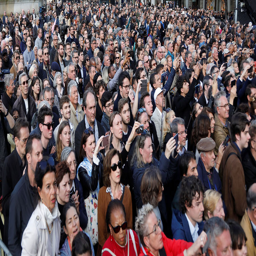

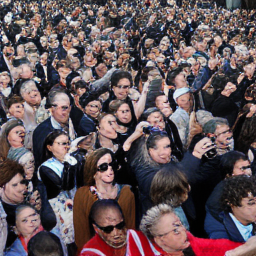

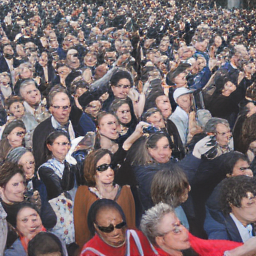

In [20]:
img_url='https://img.gazeta.ru/files3/291/12697291/upload-RTX75B8J-pic905-895x505-4746.jpg'

def map_pixels(x, eps=0.1):
    return (1 - 2 * eps) * x + eps

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x


def unmap_pixels(x, eps=0.1):
    return torch.clamp((x - eps) / (1 - 2 * eps), 0, 1)

def reconstruct_with_vqgan(x, model):
    with torch.no_grad():
        z, _, [_, _, indices] = model.encode(x)
        xrec = model.decode(z)
    return xrec

img=download_image(img_url)
display(img.resize((256,256)))

x=preprocess(img,target_image_size=256,map_dalle=False).to(DEVICE)
x=preprocess_vqgan(x) #!!!
#x=map_pixels(x)
out1=reconstruct_with_vqgan(x,model)[0] # returns array
#x=unmap_pixels(x)
out1=vqgan_postprocess(out1)

x=map_pixels(x)
out2=reconstruct_with_vqgan(x,model)[0] # returns array
#x=unmap_pixels(x)
out2=vqgan_postprocess(out2)

display(out1,out2)

#out1 better